<h1>Multi-Label Classification of Satellite Photos of the Amazon Rainforest</h1>

The dataset can be downloaded from the Planet Data page:
https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data
    
The specific files required are as follows:
<ul>
 <li>train-jpg.tar.7z (600MB)</li>
 <li>train_v2.csv.zip (159KB)</li>
</ul>

Select path to data downloaded

In [1]:
import os
os.getcwd()
%cd input

'D:\\python_projects\\Amazon'

<h2>Visualize Dataset</h2>

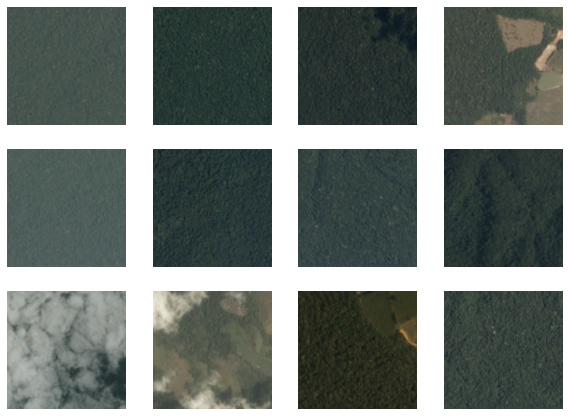

In [102]:
#Plot the random 12 images in the Planet dataset
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.image import imread
import random
from PIL import Image 

# define location of dataset
folder = 'train-jpg/'

# plot first few random images
img_num = 12
images = []
for image in os.listdir(folder):
    images.append(os.path.join(folder, image))
plt.figure(1, figsize=(10, 10))
plt.axis('off')

n = 0
for i in range(img_num):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(4, 4, n)
  plt.axis('off')
  plt.imshow(imgs)
plt.show()

<h2>Create Mappings</h2>

In [83]:
# load and summarize the mapping file for the planet dataset
import pandas as pd
# load file as CSV
filename = 'train_v2.csv'
mapping_csv = pd.read_csv(filename)
# summarize properties
print(mapping_csv.shape)
mapping_csv.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [84]:
# create a mapping of tags to integers given the loaded mapping file
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

In [85]:
mapping, inv_mapping = create_tag_mapping(mapping_csv)
print(len(mapping))
print(mapping)

17
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


In [86]:
# Create a mapping of filename to tags
def create_file_mapping(mapping_csv):
	mapping = dict()
	for i in range(len(mapping_csv)):
		name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
		mapping[name] = tags.split(' ')
	return mapping

<h2>Create In-Memory Dataset</h2>

We can now load the input (photos) and output (one hot encoded vector) elements for the entire training dataset.
The load_dataset() function below implements this given the path to the JPEG images, the mapping of files to tags, and the mapping of tags to integers as inputs;
it will return NumPy arrays for the X and y elements for modeling.

In [18]:
def load_dataset(folder, file_mapping, tag_mapping):
	photos, targets = list(), list()
	# enumerate files in the directory
	for filename in listdir(folder):
		# load image
		photo = load_img(folder + filename, target_size=(128,128))
		# convert to numpy array
		photo = img_to_array(photo, dtype='uint8')
		# get tags
		tags = file_mapping[filename[:-4]]
		# one hot encode tags
		target = one_hot_encode(tags, tag_mapping)
		# store
		photos.append(photo)
		targets.append(target)
	X = asarray(photos, dtype='uint8')
	y = asarray(targets, dtype='uint8')
	return X, y

In [19]:
# load the mapping file
filename = 'train_v2.csv'
# load the mapping file
mapping_csv = read_csv(filename)

In [20]:
# create a mapping of tags to integers
tag_mapping, _ = create_tag_mapping(mapping_csv)

In [21]:
# create a mapping of filenames to tag lists
file_mapping = create_file_mapping(mapping_csv)

In [23]:
# load the jpeg images
folder = 'train-jpg/'

In [24]:
X, y = load_dataset(folder, file_mapping, tag_mapping)
print(X.shape, y.shape)

(40479, 128, 128, 3) (40479, 17)


In [ ]:
# save both arrays to one file in compressed format
savez_compressed('planet_data.npz', X, y)

In [3]:
# load prepared planet dataset
from numpy import load
data = load('planet_data.npz')
X, y = data['arr_0'], data['arr_1']
print('Loaded: ', X.shape, y.shape)

Loaded:  (40479, 128, 128, 3) (40479, 17)


<h2>Model Evaluation Measure</h2>

In [4]:
# test f-beta score
from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# load dataset
trainX, trainY, testX, testY = load_dataset()
# make all one predictions
train_yhat = asarray([ones(trainY.shape[1]) for _ in range(trainY.shape[0])])
test_yhat = asarray([ones(testY.shape[1]) for _ in range(testY.shape[0])])
# evaluate predictions
train_score = fbeta_score(trainY, train_yhat, beta = 2, average='samples')
test_score = fbeta_score(testY, test_yhat, beta = 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)
All Ones: train=0.484, test=0.484


<h2>How to Evaluate a Baseline Model</h2>

In [5]:
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [10]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=32)
	test_it = datagen.flow(testX, testY, batch_size=32)
	# define model
	model = define_model()
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

In [8]:
# entry point, run the test harness
run_test_harness()

(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)
> loss=0.765, fbeta=0.829


<h2>How to Improve Model Performance</h2>

In [ ]:
import os
os.getcwd()
%cd input

# baseline model with data augmentation for the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import gradient_descent_v2
SGD = gradient_descent_v2.SGD
 
# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY
 
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score
 
# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(out_shape, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow(trainX, trainY, batch_size=32)
	test_it = test_datagen.flow(testX, testY, batch_size=32)
	# define model
	model = define_model()
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=200, verbose=0)
    # save model
	model.save('final_model.h5')
	# evaluate model
	loss, fbeta = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

D:\python_projects\Amazon\input
(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)


<h2>How to Use Transfer Learning</h2>

In [1]:
import os
os.getcwd()
%cd input

# vgg16 transfer learning on the planet dataset
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import gradient_descent_v2
SGD = gradient_descent_v2.SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	# separate into train and test datasets
	trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=1)
	print(trainX.shape, trainY.shape, testX.shape, testY.shape)
	return trainX, trainY, testX, testY

# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Fbeta')
	pyplot.plot(history.history['fbeta'], color='blue', label='train')
	pyplot.plot(history.history['val_fbeta'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterators
	train_it = datagen.flow(trainX, trainY, batch_size=32)
	test_it = datagen.flow(testX, testY, batch_size=32)
	# define model
	model = define_model()
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	loss, fbeta = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

D:\python_projects\Amazon\input
(28335, 128, 128, 3) (28335, 17) (12144, 128, 128, 3) (12144, 17)
58900480/58889256 [==============================] - 1s 0us/step
> loss=0.220, fbeta=0.858


<h2>How to Finalize the Model and Make Predictions</h2>

In [1]:
import os
os.getcwd()
%cd input

# save the final model to file
from numpy import load
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import gradient_descent_v2
SGD = gradient_descent_v2.SGD

# load train and test dataset
def load_dataset():
	# load dataset
	data = load('planet_data.npz')
	X, y = data['arr_0'], data['arr_1']
	return X, y

# define cnn model
def define_model(in_shape=(128, 128, 3), out_shape=17):
	# load model
	model = VGG16(include_top=False, input_shape=in_shape)
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# allow last vgg block to be trainable
	model.get_layer('block5_conv1').trainable = True
	model.get_layer('block5_conv2').trainable = True
	model.get_layer('block5_conv3').trainable = True
	model.get_layer('block5_pool').trainable = True
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(out_shape, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy')
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	X, y = load_dataset()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow(X, y, batch_size=32)
	# define model
	model = define_model()
	# fit model
	model.fit(train_it, steps_per_epoch=len(train_it), epochs=50, verbose=0)
	# save model
	model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

D:\python_projects\Amazon\input


<h2>Make a prediction for a new image</h2>

In [7]:
from pandas import read_csv
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list to list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

# convert a prediction to tags
def prediction_to_tags(inv_mapping, prediction):
	# round probabilities to {0, 1}
	values = prediction.round()
	# collect all predicted tags
	tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
	return tags

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(128, 128))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 128, 128, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

# load an image and predict the class
def run_example(inv_mapping):
	# load the image
	img = load_image(sample_image)
	# load model
	model = load_model('final_model.h5')
	# predict the class
	result = model.predict(img)
	print(result[0])
	# map prediction to tags
	tags = prediction_to_tags(inv_mapping, result[0])
	print(tags)

# load the mapping file
sample_image = r"D:\python_projects\Amazon\input\train-jpg\train_126.jpg"
filename = 'train_v2.csv'
mapping_csv = read_csv(filename)
# create a mapping of tags to integers
_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping)

[9.9940884e-01 7.2695587e-12 2.0855024e-08 6.5252398e-10 8.2548570e-15
 9.9999797e-01 1.1878200e-14 4.4686410e-10 6.0336711e-04 2.3467825e-05
 7.4140241e-09 1.8966094e-06 9.9999869e-01 9.9510717e-01 6.4961936e-10
 1.1206025e-08 8.7439297e-03]
['agriculture', 'clear', 'primary', 'road']
